In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Dataset

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data.columns.tolist()

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

### EDA

<Axes: xlabel='median_house_value', ylabel='Count'>

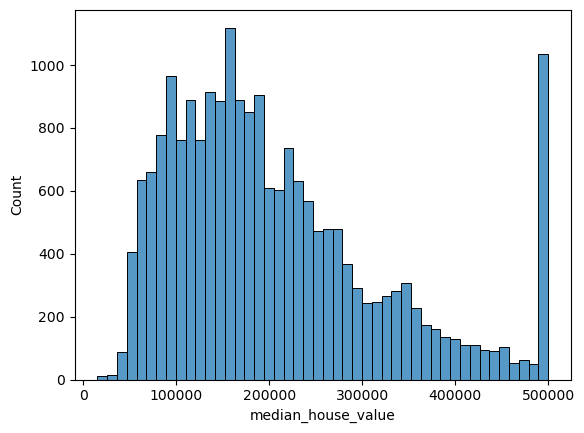

In [5]:
sns.histplot(data.median_house_value)

In [6]:
median_house_value_logs = np.log1p(data.median_house_value)

<Axes: xlabel='median_house_value', ylabel='Count'>

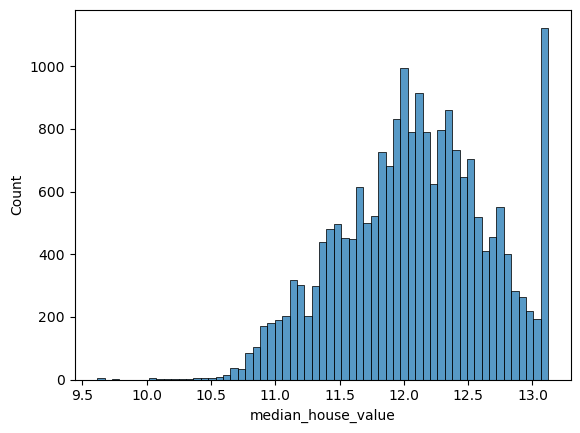

In [7]:
sns.histplot(median_house_value_logs)

### Preparing the dataset

In [8]:
selected_columns = ['longitude',
                     'latitude',
                     'housing_median_age',
                     'total_rooms',
                     'total_bedrooms',
                     'population',
                     'households',
                     'median_income',
                     'median_house_value']
df = data.loc[data.ocean_proximity.isin(['<1H OCEAN', 'INLAND']), selected_columns].reset_index(drop=True)

In [9]:
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
1,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
2,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0


### Question 1

There's one feature with missing values. What is it?

In [10]:
df.isnull().sum()[df.isnull().sum() > 0].index.tolist()

['total_bedrooms']

### Question 2

What's the median (50% percentile) for variable `population`?

In [11]:
df.population.median()

1195.0

### Prepare and split the dataset

In [12]:
n = len(df)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [13]:
df_train.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
15183,-119.14,36.23,22.0,2935.0,523.0,1927.0,530.0,2.5875,70400.0
4469,-117.79,34.12,16.0,2426.0,426.0,1319.0,446.0,4.8125,224500.0
9316,-117.97,33.68,26.0,3653.0,568.0,1930.0,585.0,5.7301,260900.0


In [14]:
len(df_train), len(df_val), len(df_test)

(9413, 3137, 3137)

In [15]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [16]:
y_train = np.log1p(df_train.median_house_value.to_numpy())
y_val = np.log1p(df_val.median_house_value.to_numpy())
y_test = np.log1p(df_test.median_house_value.to_numpy())

In [17]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

### Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [18]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

def rmse(y, y_pred):
    se = (y - y_pred)**2
    mse = se.mean()
    return np.sqrt(mse)

In [19]:
X_train_fillnawith0 = df_train.fillna({"total_bedrooms": 0}).to_numpy()
X_train_fillnawithmean = df_train.fillna({"total_bedrooms": df_train.total_bedrooms.mean()}).to_numpy()

In [20]:
w0_fillnawith0, w_fillnawith0 = train_linear_regression(X_train_fillnawith0, y_train)
w0_fillnawithmean, w_fillnawithmean = train_linear_regression(X_train_fillnawithmean, y_train)

In [21]:
X_val_fillnawith0 = df_val.fillna({"total_bedrooms": 0}).to_numpy()
X_val_fillnawithmean = df_val.fillna({"total_bedrooms": df_train.total_bedrooms.mean()}).to_numpy()

In [22]:
y_pred_fillnawith0 = w0_fillnawith0 + X_val_fillnawith0.dot(w_fillnawith0)
y_pred_fillnawithmean = w0_fillnawithmean + X_val_fillnawithmean.dot(w_fillnawithmean)

In [23]:
print(f"RMSE (NaNs filled with zero): {round(rmse(y_pred_fillnawith0, y_val), 2)}")
print(f"RMSE (NaNs filled with mean): {round(rmse(y_pred_fillnawithmean, y_val), 2)}")

RMSE (NaNs filled with zero): 0.34
RMSE (NaNs filled with mean): 0.34


### Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which `r` gives the best RMSE?

In [24]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX = XTX + r*np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

In [25]:
X_train = df_train.fillna({"total_bedrooms": 0}).to_numpy()
X_val = df_val.fillna({"total_bedrooms": 0}).to_numpy()

In [26]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = w0 + X_val.dot(w)
    print(f"RMSE (r={r}): {round(rmse(y_pred, y_val), 2)}")

RMSE (r=0): 0.34
RMSE (r=1e-06): 0.34
RMSE (r=0.0001): 0.34
RMSE (r=0.001): 0.34
RMSE (r=0.01): 0.34
RMSE (r=0.1): 0.34
RMSE (r=1): 0.34
RMSE (r=5): 0.35
RMSE (r=10): 0.35


### Question 5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
- Round the result to 3 decimal digits (`round(std, 3)`)

In [27]:
rmses = {}

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    
    df_train.reset_index(drop=True, inplace=True)
    df_val.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    y_train = np.log1p(df_train.median_house_value.to_numpy())
    y_val = np.log1p(df_val.median_house_value.to_numpy())
    y_test = np.log1p(df_test.median_house_value.to_numpy())
    
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    
    X_train = df_train.fillna({"total_bedrooms": 0}).to_numpy()
    X_val = df_val.fillna({"total_bedrooms": 0}).to_numpy()

    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)
    
    rmses[s] = round(rmse(y_pred, y_val), 2)
    print(f"RMSE (seed={s}): {rmses[s]}")

print(f"Standard deviation of all the RMSE scores: {round(np.std([*rmses.values()]), 3)}")

RMSE (seed=0): 0.33
RMSE (seed=1): 0.34
RMSE (seed=2): 0.34
RMSE (seed=3): 0.34
RMSE (seed=4): 0.34
RMSE (seed=5): 0.34
RMSE (seed=6): 0.34
RMSE (seed=7): 0.34
RMSE (seed=8): 0.34
RMSE (seed=9): 0.34
Standard deviation of all the RMSE scores: 0.003


### Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with `r=0.001`.
- What's the RMSE on the test dataset?

In [28]:
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train_val = pd.concat([df_train, df_val])

df_train_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

y_train_val = np.log1p(df_train_val.median_house_value.to_numpy())
y_test = np.log1p(df_test.median_house_value.to_numpy())

del df_train_val['median_house_value']
del df_test['median_house_value']

X_train_val = df_train_val.fillna({"total_bedrooms": 0}).to_numpy()
X_test = df_test.fillna({"total_bedrooms": 0}).to_numpy()

w0, w = train_linear_regression_reg(X_train_val, y_train_val, r=0.001)
y_pred = w0 + X_test.dot(w)

print(f"RMSE on the test set: {round(rmse(y_pred, y_test), 2)}")

RMSE on the test set: 0.34
